[方法指引](https://docs.google.com/document/d/1nPLGlZV4Zyc6gQkpfBicruGNJMhlB7ZlPID_-vudlQU/edit?usp=sharing)
## 一、 探索外觀特徵與科之間的關係
### 建立簡易的分科模型，提供後續GradCam分析方法，視覺化檢視分科特徵

- 為了進一步了解物種的外觀特徵與科之間的關係，我們首先以代表外觀特徵的 latent vector 為輸入資料，訓練簡單的神經網路模型學習分科，並評估分科表現。為了後續解讀方便，我們將外觀特徵值轉換為非負值。

- 做法是先將對應每張標本影像的 512 維特徵重複堆疊為 1024 維，保留前 512 維裡的正值，與後 512 維裡的負值並取絕對值，其餘維度設為 0。如此即會得到內容全為非負值的外觀特徵。

- 以此為 input，訓練僅兩層全連接 hidden layers (每層各 512 個神經元) 的簡單模型，學習分科 (42 科)，在測試資料集中可達到 90.1% top-1 accuracy。

In [1]:
import os,  time, random, glob
import torch
import numpy as np 
import pandas as pd
# import PIL
import skimage.io
import skimage.transform
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torch.autograd import Variable

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

path_root =  '/home/jovyan/Autoencoder'

#### 建立簡易兩層全連結層的模型

In [2]:
# Define model
class Family_Predictor(nn.Module):
    def __init__(self, in_features=1024, n_neurons=512, n_classes=90):
        super().__init__()
#         super().__init__()
        self.family_Predictor = nn.Sequential(
            nn.Linear(in_features, n_neurons),
            nn.LeakyReLU(negative_slope=0.02, inplace=True),
            nn.Linear(n_neurons, n_classes),
        )

    def forward(self, x):
        pre = self.family_Predictor(x)
        return pre 
    
model = Family_Predictor(in_features=1024, n_neurons=256, n_classes=90) 


In [3]:
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [4]:
# # Define model
# class Moth_FamilyPrediction(nn.Module):
#     def __init__(self, in_features=1024, n_neurons=256, n_classes=97, n_layers=2, shrink_rate=2):
#         super(Moth_FamilyPrediction, self).__init__()
        
#         predic_family = [
#             nn.Linear(in_features, n_neurons),
#             nn.LeakyReLU(negative_slope=0.02, inplace=True)
#         ]
        
#         for _ in range(n_layers):
#             predic_family.extend([
#                 nn.Dropout(0.5),
#                 nn.Linear(n_neurons, int(n_neurons//shrink_rate)),
#                 nn.LeakyReLU(negative_slope=0.02, inplace=True)
#             ])
#             n_neurons //= shrink_rate
#             n_neurons =  int(n_neurons)
        
#         predic_family.extend([
#                 nn.Linear(n_neurons, n_classes),
# #                 nn.LeakyReLU(negative_slope=0.02, inplace=True)
#             ])
#         self.predic_family = nn.Sequential(*predic_family)

#     def forward(self, x):
#         pre = self.predic_family(x)
#         return pre 

# model = Moth_FamilyPrediction(in_features=1024, n_neurons=256, n_classes=97, n_layers=0, shrink_rate=1) 
# model

In [5]:
# # 評估模型摘要
# from torchsummary import summary
# device = torch.device("cpu")
# input_size = (1, 1024)
# batch_size = 64

# summary(model.to(device), input_size=input_size, batch_size=batch_size, device='cpu')

### 資料準備
1. 將對應每張標本影像的 512 維特徵重複堆疊為 1024 維，保留前 512 維裡的正值，與後 512 維裡的負值並取絕對值，其餘維度設為 0。如此即會得到內容全為非負值的外觀特徵。
2. 選取僅物種數超過3種的科
3. 盎樣本類別比例抽樣分配，確保小樣本優先分配至訓練資料集，並在訓練集驗證資料集中均有同樣比例


In [6]:
# 讀取特徵值(Latent Vector)，並做轉換
ck = 4300
features = np.load(f'./meta/features_ck{ck}.npy') # features.shape = (32262, 512)

f_pos = np.where(features > 0, features, 0)              # 保留正值，將其他維(負值)設為0 
f_neg = np.abs(np.where(features < 0, features, 0))      # 保留負值，將其他維(正值)設為0，最後取絕對值  
features_1024 = np.concatenate((f_pos, f_neg), axis=1)   # 將原本的512為堆疊為1024維 shape = (32262, 1024)
print(features_1024.shape)

(32262, 1024)


In [7]:
# 讀取蛾類科別metadata
moth_meta = pd.read_csv(f'./meta/moth_meta_20210610.csv')

# 取得檔案名稱加入欄位內
dataroot = "/home/jovyan/Autoencoder/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210610"
image_list = glob.glob(dataroot + '/*.jpg')  # 如果資料乾淨的話，可直接用 os.listdir(dataroot)
moth_meta['ImgPath'] = image_list

moth_meta 

,Family,Subfamily,Genus,Species,SciName,Number,Source,Family_encode,Fam_Sample,Fam_Specie,ImgPath
0,Notodontidae,Phalerinae,Datana,perspicua,Datana perspicua,2432375495,CSU,60,741,530,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
1,Geometridae,Ennominae,Borbacha,pardaria,Borbacha pardaria,A37-20180907-057,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
2,Geometridae,Ennominae,Cleora,fraterna,Cleora fraterna,A34-20130506-024,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
3,Tortricidae,Olethreutinae,Olethreutes,osmundana,Olethreutes osmundana,1838875462,MISSA,84,938,802,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
4,Geometridae,Geometrinae,Hemistola,monotona,Hemistola monotona,A52-20160704-154,TESRI,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
...,...,...,...,...,...,...,...,...,...,...,...
32257,Tineidae,Tineinae,Tinea,occidentella,Tinea occidentella,2432338673,CSU,82,102,85,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32258,Geometridae,Geometrinae,Episothalma,robustaria,Episothalma robustaria,1826442741,NHMUK,34,4684,3138,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32259,Oecophoridae,Depressariinae,Eupragia,hospita,Eupragia hospita,1585226502,MISSA,62,70,65,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...
32260,Nymphalidae,Limenitidinae,Neptis,hylas,Neptis hylas,1039028551,YPM,61,3999,1655,/home/jovyan/Autoencoder/wolrdwide_lepidoptera...


In [8]:
# from sklearn.model_selection import train_test_split
  
# mask = (moth_meta.Fam_Specie > 3)    # 篩選物種數超過3的科(65科) 
# X = features_1024[mask]
# y = moth_meta[mask].Family_encode    # 科名編碼
# X_train, X_valid, y_train, y_valid  = train_test_split(X, y, test_size=0.4, random_state=10, stratify=y)  # 按照y的類別比例取樣

# # 檢視各類別切分比例及數量是否在訓練跟驗證資料集都一致
# print(f'X_train:{X_train.shape}, y_train:{y_train.shape},\nX_valid:{X_valid.shape},  y_valid:{y_valid.shape}')
# # print(f'Class Pro of y_train:\n{np.round(np.bincount(y_train)/y_train.size,3)}')
# # print(f'Class Pro of y_valid:\n{np.round(np.bincount(y_valid)/y_valid.size, 3)}')  
# print(f'Class count of y_train:\n{np.bincount(y_train)}')  # 檢視各類別切分數量，0~96
# print(f'Class count of y_valid:\n{np.bincount(y_valid)}') 

# # save meta data 
# dict_data = {'X_train':X_train, 'y_train':y_train, 'X_valid':X_valid, 'y_valid':y_valid}
# for k, v in dict_data.items():
#     np.save(f'./meta/{k}.npy', v)

In [9]:
# load training data
X_train, y_train, X_valid, y_valid = [np.load(f'./meta/{f}.npy', allow_pickle=True) 
                                      for f in ['X_train', 'y_train', 'X_valid', 'y_valid']]
print(f'X_train:{X_train.shape}, y_train:{y_train.shape},\nX_valid:{X_valid.shape},  y_valid:{y_valid.shape}')

X_train:(19308, 1024), y_train:(19308,),
X_valid:(12872, 1024),  y_valid:(12872,)


In [10]:
# 準備訓練用的Dataset
class MothFeatureDataset(Dataset):
    def __init__(self, X, y, normalize=False):
        """ 為latent features訓練分科模型用的Dataset
            image_root: path to image file
            X : 放置numpy或list格式資料，這裡的X是形狀為(n,1024) 的蛾類型態Feature Vector
            y : 放置numpy或list格式標籤，這裡為蛾類的科(eccode編碼) 
        """         
        self.X,  self.y= torch.tensor(X), torch.tensor(y)
        self.normalize = normalize  # 將Features座標準化
        
    def __getitem__(self, index):
        feature = self.X[index]
        label = self.y[index]
        if self.normalize:
            def __normalMinMax(features):
                # 將features值 縮放至(0,1)之間
                features_normal = (features - features.min()) / features.max()
                return features_normal
            feature = __normalMinMax(feature)    # 標準化為 0 - 1 分布
        return feature, label
    
    def __len__(self):
        return len(self.y)
        
    # help to get images for visualizing
    def getbatch(self, indices):
        features = []
        labels = []
        for index in indices:
            feature, label = self.__getitem__(index)
            features.append(feature)
            labels.append(label)
        return torch.stack(features), labels


class ImgDataset(Dataset):
    '''簡單用來抽樣看原始圖檔的Dataset
        X: ImagePath
        y: Imagelabel(Family, Genus ,Specie Name etc...)
    '''
    def __init__(self, X, y):
        self.ImgNames  = np.asarray(X)                # 輸入的X 為影像完整路徑的list、y則為完整的科名list 
        self.labels = np.asarray(y)
        self.to_tensor = transforms.ToTensor()        # 將取值範圍為[0, 255]的PIL.Image或形狀為[H, W, C]的numpy.ndarray，轉換成形狀為[C, H, W]，取值範圍是[0, 1.0]的torch.FloadTensor
#         self.transform = transforms.Compose([       # 影像必須用PIL開啟才能使用transforms.Compose等系列操作
#             transforms.Resize(size=(128, 128)),
#             transforms.ToTensor()
#         ])
        
    def __getitem__(self, index):
        img_Name = self.ImgNames[index]
#         image = PILImage.open(img_Name)                #  PIL Image讀讀取影像的通道為(c,w,h)
        image = skimage.io.imread(img_Name)              #  skimage.io讀取影像的通道為(w,h,c)，to_tensor會自動調整  
        image = skimage.transform.resize(image, (128,128))
        image = self.to_tensor(image)                    # 根據檔名開啟影像。得到image.jpg的物件，並轉為Tensor
        label  = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.labels)
    
    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), labels

# 一次預讀取讀取所有影像 
# X = moth_meta.ImgPath
# y = moth_meta.Family
# img_set = ImgDataset(X=X, y=y)

In [11]:
# # 設定參數
batch_size  = 500
# num_workers = 2
# pin_memory  = True
# drop_last   = True

# # 客製Dataset載入資料
# train_set = MothFeatureDataset(X=X_train, y=y_train, normalize=True)
# valid_set = MothFeatureDataset(X=X_valid, y=y_valid, normalize=True)

# # DataLoader將資料把包成批次
# train_loader = DataLoader(dataset=train_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory, drop_last=drop_last)
# valid_loader = DataLoader(dataset=valid_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

# # 檢視資料形狀、大小
# print(f'Train size : {len(train_set):5d}, iter_size: {len(train_loader):4d}')
# print(f'Valid size : {len(valid_set):5d}, iter_size: {len(valid_loader):4d}')

# features, labels = next(iter(train_loader))
# print('Train data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 
# features, labels = next(iter(valid_loader))
# print('Valid data set:', features.shape, labels.shape)   # (batch_size, channel, w, h) 


### 定義訓練用函式

In [12]:
model_name = f'Family_Predictor_Batch{batch_size}_Warmpup' 
path = f'./model/family_Predictor/{model_name}.pth'

# 呼叫模型檢查點(Checkpoint)儲存與載入函式
def save_checkpoint(model, optimizer=None, path=None, epoch=None, best_loss=None):
    state = {'model_state_dict'    : model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'epoch':epoch,
             'best_loss':best_loss}
    torch.save(state , path)

def load_checkpoint(model, path, optimizer=None):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch_ = checkpoint['epoch']
    best_loss_ = checkpoint['best_loss']
    
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(optimizer)

    print(f'best_loss:{best_loss_:.4f}')
    print(f'{model_name}.pth loaded!')
    return model

In [13]:
# # 檢查變數是否已命名
# try:
#     train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log
#     print('log file has bean setted')
# except NameError:
#     train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log  = [], [], [], [], []
#     print('log file resetted:\n    train_log, valid_log, train_Acc_log, valid_Acc_log, lr_log')

# # 檢查資料夾是否已建立
# logRoot =  "./model/family_Predictor"
# if not os.path.isdir(f'{logRoot}'):
#     os.mkdir(f'{logRoot}')
#     print(f'"{logRoot}" folder made!')
    
# # save Loss log
# def save_log(fileName=None):
#     '''儲存學習過程'''
#     (pd.DataFrame({"train_Loss":train_log   , 'valid_Loss':valid_log, 
#                    'train_Acc':train_Acc_log, 'valid_Acc' :valid_Acc_log,
#                    'lr':lr_log})
#        .to_csv(f'{logRoot}/Loss_log_{fileName}.csv', index=False))

# def getAccuracy(pred, labels, correct, total):
#     '''計算分類正確率，在train及evaluate函式中使用'''
#     pred_ = torch.argmax(pred, dim=1)              # 取得最大值的索引位置(0~9)
#     correct += (pred_ == labels).sum().item()      # 累加預測正確的樣本數
#     total += labels.size(0)                        # 累加每批次樣本數
#     return (100*correct / (total+1e-10))             # 回傳分類正確率


# def train(model, optimizer, dataloader, device):
#     '''訓練模型，輸入訓練資料集'''
#     running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
#     model.train()  # 明確指定model在訓練狀態(預設值)
#     for i, (inputs, labels) in enumerate(dataloader):
#         inputs, labels = inputs.to(device), labels.to(device)  
#         optimizer.zero_grad()                          # 將優化器梯度歸零 
#         pred = model(inputs)                            
#         loss = criterion(pred, labels)                 # 計算LOSS ， 調整為形狀一致
#         loss.backward()                                # 反向傳導
#         optimizer.step()                               # 更新參數
#         running_loss += loss.item()                    # 累加這輪epoch的loss 
#         # get accuracy
#         acc = getAccuracy(pred, labels, correct, total)     
#     # 每輪epoch結束後取平均loss、計算分類正確率 
#     mean_loss = running_loss/i
#     train_log.append(mean_loss); train_Acc_log.append(acc)
#     lr_log.append(optimizer.param_groups[0]['lr']) 
#     return mean_loss , acc                             # 回傳平均loss, 分類正確率  

# def evaluate(model, dataloader, device):
#     '''評估模型，輸入驗證/測試資料集'''
#     running_loss, correct ,total = 0.0, 0.0, 0.0   # 每輪歸零重計
#     model.eval() # 啟動評估模式
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloader):  
#             inputs, labels = inputs.to(device), labels.to(device)
#             pred = model(inputs)
#             loss = criterion(pred, labels)
#             running_loss += loss.item()
#             acc = getAccuracy(pred, labels, correct, total) 
            
#         # 每輪epoch結束後取平均loss
#     mean_loss = running_loss/i
#     valid_log.append(mean_loss); valid_Acc_log.append(acc)
#     return mean_loss , acc

# def early_stop(valid_loss, best_loss, trigger_times, patience):
#     '''早停機制
#     trigger_times: 計數次數
#     patience:　啟動後。等待幾回合
#     '''
#     if valid_loss > best_loss:
#         trigger_times += 1
#         print('  trigger times:', trigger_times)
#     else:
#         trigger_times = 0
        
#     if trigger_times >= patience:
#         print('  Early stopping!')
#     return trigger_times

In [14]:
# # 設定optimizer
# import torch.optim as optim
# from torch.optim import lr_scheduler

# criterion = nn.CrossEntropyLoss() 
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)


In [15]:
# def training_model(n_epoch, optimizer, scheduler):
#     start = time.time()
#     best_loss=1e10 ; patience=20 ; trigger_times=0 # 設定初始值
#     for epoch in range(n_epoch):  # loop over the dataset multiple times
#         pass_ = time.time() - start
#         print(f'Epoch:{epoch+1 :3d}.  Time Passed: {pass_//(60*60):3.0f}h,{pass_//60%60:2.0f}m,{pass_%60:2.0f}s')
        
#         train_loss, valid_loss= 0.0, 0.0 # 每輪重新歸零

#         train_loss, train_Acc = train(model, optimizer, train_loader, device)
#         print(f'  Train Loss: {train_loss:,.3f}. Acc: {train_Acc:,.2f}%')

#         valid_loss, valid_Acc = evaluate(model, valid_loader, device)             
#         print(f'  Valid Loss: {valid_loss:,.3f}. Acc: {valid_Acc:,.2f}%')

#         # 擷取最佳模型
#         if best_loss > valid_loss:
#             decline = (best_loss-valid_loss)/best_loss*100
#             best_loss = valid_loss
#             save_checkpoint(model, optimizer, path, epoch, best_loss)            
#             print(f'  Best loss updated: {best_loss:,.3f}, {decline:.2f}% declined.  Model Saved!') 

#         # 更新學習速率
#         scheduler.step(valid_loss)
#         print(f'  lr_sch : {scheduler._last_lr[0]}')
        
#         # 儲存log
#         save_log(fileName=model_name)

#         # early stopping
#         trigger_times = early_stop(valid_loss, best_loss, trigger_times, patience)
#         if trigger_times >= patience:
#             print('Early stopping!')
#             break
    
#     print(f'Best val_loss: {best_loss:,.3f}')
#     print(f'Finished Training\n')


In [16]:
# # 模型預熱 Warmpup 
# optimizer = optim.Adam(model.parameters(), lr=1e-8, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(10, optimizer, scheduler)

In [17]:
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10, verbose=True)
# training_model(300, optimizer, scheduler)

In [18]:
# # 作圖
# def get_LossFig(figName=None, s=0, e=-1 , savefig=False):
#     '''繪製學習過程圖
#     Parameters
#      ----------
#        figName: str, default: None
#        s: number(int) , default: 0, start of epoch.  number(int) 
#        e: number(int) , default: 0, end of epoch. 
#        savefig: boolean
#            whether to save
#    '''
#     log = pd.read_csv(f'{logRoot}/Loss_log_{figName}.csv')
#     log = log[s:e] 
#     fig = plt.figure(figsize=(10,5))
#     ax1 = fig.add_axes([0, 0.0, 1, 0.8],)
#     ax2 = plt.twinx()
#     ax3 = fig.add_axes([0, 0.8, 1, 0.2], xticklabels=[])

#     ax1.plot(log.train_Loss, label='Train_Loss', c='tab:blue', lw=3)
#     ax1.plot(log.valid_Loss, label='Valid_Loss', c='lightblue', lw=3, ls='--'  )
#     ax2.plot(log.train_Acc, label='Train_Accuracy', c='tab:green', lw=3)
#     ax2.plot(log.valid_Acc, label='Valid_Accuracy', c='lightgreen', lw=3, ls='--' )
#     ax3.plot(np.log10(log.lr), c='grey')   # lr取log 

#     plt.title('LOSS', {'fontsize':18})
#     plt.suptitle(f'batch:{batch_size}', x=0.8, y=1.05, fontsize=12, fontweight='light')
#     ax1.set_xlabel('Epoch',{'fontsize':12}); ax1.set_ylabel('Loss',{'fontsize':12})
#     ax2.set_ylabel('Accruracy(%)',{'fontsize':12}); ax3.set_ylabel('lr(log)',{'fontsize':12})
#     ax1.grid(True)
#     fig.legend(loc='upper left', ncol=2, bbox_to_anchor=(0.7, 0.6), frameon=True, framealpha=.5, fontsize=12 ) 
    
#     # 圖片存檔
#     if savefig:       
#         plt.savefig(f'{logRoot}/Loss_{figName}.png', bbox_inches='tight')
#     fig; 
    
# get_LossFig(figName=model_name, savefig=True)

In [19]:
# load_checkpoint(model, path)

In [20]:
# # 檢視驗證資料集整體分類正確率 
# valid_loader = DataLoader(dataset=valid_set, batch_size=1280)
# correct = 0
# total = 0
# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)

#         # 計算圖片在每個類別上的分數
#         outputs = model(inputs)
#         # 得分最高的那個類別
#         _, predicted = torch.max(outputs.data, 1)
                
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# #         print(f'total : {total:5d}, correct : {correct:5d}')
# #         accuracy = (torch.argmax(outputs, dim=1) == labels).sum().item() / batch_size

# print(f'Accuracy of the network on the  valid data: {(100 * correct / total):.2f} %, Sample_Size : {total:5d}')
# # 整體分類正確率約為92%

In [21]:
# # 建立科名encoing的字典對照表 
# fam_dict = dict(zip(np.sort(moth_meta.Family.unique()), range(97) ))           # 依科名英文字母順序建立編碼

# # 檢視驗證資料集各類別分類正確率 
# classes= [k for k in fam_dict.keys()]
# n_classes = 90
# class_correct = list(0 for i in range(n_classes))
# class_total = list(0 for i in range(n_classes))
# with torch.no_grad():
#     for inputs, labels in valid_loader:
#         inputs, labels = inputs.to(device), labels.to(device) # 把資料送入GPU(非inplace)
        
#         # 計算圖片在每個類別上的分數
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(outputs.size(0)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# print('Accuracy of each class')         
# # for i in range(n_classes):
# #     accuracy = 100 * class_correct[i] / (class_total[i] + 1e-10)  # 加上極微小的數值避免分母為0
# #     print(f'Family {classes[i]:20s} : {accuracy:6.3f} %')

# acc_df = pd.DataFrame({'Family':classes, 'Correct':class_correct, 'Total':class_total})
# acc_df['Accuracy'] = acc_df.Correct / (acc_df.Total + 1e-10)  # 加上極微小的數值避免分母為0
# acc_df = acc_df.sort_values(by='Total')[::-1]

logRoot =  "./model/family_Predictor"
LogFile = f'accuracyLog_Batch500'
# acc_df.to_csv(f'{logRoot}/{LogFile}.csv', index=True)

acc_df = pd.read_csv(f'{logRoot}/{LogFile}.csv', index_col=0)
acc_df[acc_df.Total>0][:20]
acc_df['cumsum'] = acc_df["Total"].cumsum()
acc_df['Total%'] = acc_df['cumsum'] / acc_df.iloc[-1,-1]
acc_df[:20]

,Family,Correct,Total,Accuracy,cumsum,Total%
27,Erebidae,1881,2060,0.913107,2060,0.160037
34,Geometridae,1819,1874,0.970651,3934,0.305625
61,Nymphalidae,1575,1600,0.984375,5534,0.429925
58,Noctuidae,1362,1480,0.920270,7014,0.544904
65,Pieridae,1221,1233,0.990268,8247,0.640693
39,Hesperiidae,576,585,0.984615,8832,0.686140
48,Lycaenidae,485,513,0.945419,9345,0.725994
19,Crambidae,427,478,0.893305,9823,0.763129
64,Papilionidae,434,438,0.990868,10261,0.797157
84,Tortricidae,359,375,0.957333,10636,0.826290


In [22]:
## 指定物種顯示原始影像

# X = moth_meta.ImgPath
# y = moth_meta.Family
# img_set = ImgDataset(X=X, y=y)

# specie = 'Anthocharis sara'
# img_indices =  moth_meta[moth_meta.SciName == specie].index

# images ,labels = img_set.getbatch(img_indices)
# family_ = np.unique(labels).item()
# im_convert(torchvision.utils.make_grid(images, nrow=6), f_name= f'{family_}_{specie}', subtitle=len(y), save=False)

#### 訓練結果note
- 數量排名前五大科，占總樣本數的65%、數量排名前十大科，占總樣本數的83.5%、數量排名前二十大科，占總樣本數的95.8%
- 數量排名前十大科，平均分類正確率達96.6%、數量排名前二十大科，平均分類正確率達90.1%
- 各科狀況討論
  - 數量排名前五大科中，除裳蛾科Erebidae、夜蛾科Noctuidae外，分類正確率都達98%以上
     - 可能反映屬夜蛾總科下的這兩科型態上多有相似之處
     - 可檢視這兩科的分類標籤是否分配到彼此
  - Sesiidae 透翅蛾科雖然樣本不多，但因為翅型特殊，仍可以取得很高的分類正確率97.8%, n=46 (from validation dataset)
  - 數量前二十大的科別中，瘤蛾科Nolidae(57.0%)、鉤蛾科Drepanidae(65.2%)是分類預測表現相對差的類群
  - 數量前三十大的科別中，蜆蝶Riodinidae~分類正確率為0.0%，異常的低(總物種28、總樣本60)~
     - 總科數量較正為90後，蜆蝶Riodinidae分類正確率為提升為77%左右，原樣本有重新整理過(總物種148、總樣本增加至276)
- 檢視分類錯誤的標籤即對應的科名、與原圖
- 檢視GradCAM分類所對應的區域?
  - 目前是用特徵訓練，因此反向傳播回推也只能到特徵維度
  - 除非用當初映妤訓練用的ResNet50模型回去檢視

In [23]:
## 檢視各科樣本數量分布
# moth_sample = (moth_meta.groupby(by='Family')[['SciName','DataID']]
#                .nunique().rename(columns={'SciName':'n_Species', 'DataID':'n_Samples'})
#                .sort_values(by='n_Species')[::-1] )
# moth_sample['n_Species%'] = np.round(100 * moth_sample.iloc[:,0] / moth_sample.n_Species.sum(), 3)
# moth_sample['n_Samples%'] = np.round(100 * moth_sample.iloc[:,1] / moth_sample.n_Samples.sum(), 3)
# moth_sample[:10]


#### 抽樣檢視原始影像

In [24]:
# # 建立科名encoing的字典對照表 - YY版本
# worldwide_family = np.load('./meta/worldwide_family.npy') 
# fam_dic_YY = dict(zip(range(97), worldwide_family))                  # 依YY檔案建立科名排序編碼

# # 建立物種名的字典對照表
# n_species = moth_meta.SciName.nunique()  # 17186
# species_list = moth_meta.sort_values(by='SciName').SciName.unique()
# spe_dict = dict(zip(range(n_species), species_list))

# dataroot = "/home/jovyan/Autoencoder_Practice/wolrdwide_lepidoptera_yolov4_cropped_and_padded_20210407"
# image_list = glob.glob(dataroot + '/*.jpg')
# moth_meta['ImgName'] = image_list

In [25]:
import torchvision 
def im_convert(tensor, f_name=None, subtitle=None, save=False):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
    plt.figure(figsize=(12, 6))
    plt.title(f'{f_name}', fontsize=24)
    plt.imshow(image)
    
    if save:
        fig_Name =  f"./results/imgsample/{f_name}_{subtitle}_Sampled.png"
        plt.savefig(fig_Name, bbox_inches='tight')
        print(f'{fig_Name} Saved')
        
# for k, v in fam_dic_YY.items():
#     sample = v
#     mask = (moth_meta.Family== sample) 
#     X = moth_meta[mask].ImgName
#     y = moth_meta[mask].Family
#     print(f'{v}, datasize: {len(y)}')

#     data_set = ImgDataset(X=X, y=y)
#     data_loader = DataLoader(dataset=data_set, shuffle=True, num_workers=0, batch_size=60)

#     images, labels = next(iter(data_loader))
#     im_convert(torchvision.utils.make_grid(images, nrow=10), f_name=sample, subtitle=len(y), save=True)
#     plt.close()

### 分科模型訓練筆記
- 整體分類正確率的極限大約在92-93%，各類別的分類正確率不太受batch size影響，也不太受Warmup影響，可能跟模型太過簡單有關
- Batch size
  - 不同Batch size設定最後得到的結果其實沒差異太大
  - 設定太小的話，每輪loss跳動會較大，但也會換來較快的參數更新次數，可以幫助更快達到收斂
  - 但batch size大的話，用gpu運算速度會快很多

## 二、找出關鍵特徵
- 接著我們將找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。

- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。

- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 
      
- 我們希望以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ 50 這個範圍中對應的 N-union 個關鍵特徵。基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)，標準化並加總評估後得到當 N=2, N-union=34 時有最佳的科分群結果，約為總特徵數的 6.6% (34/512)。
  - 指定從原本512個特徵位置中，僅採用這1 - 50個特徵位置來進行分群，嘗試找出 N(1-50) x  N-union(1-50) 對於分群結果的最佳解
    - N(1D、2D、3D ~ 50D)空間維度；理論上越高越好?  但人類能視覺化理解的上限最多到3D  => 這邊只採用 2D、3D
    - N-union(1 ~ 512) 特徵位置：

- 為了更進一步理解關鍵特徵的視覺意義，我們對其做 PCA，找出最主要的三軸(解釋度 34.9%)。接著在三軸上均勻取樣並 inverse transform 回關鍵特徵。從 decoder 生成的影像中，可明確看出每一軸在外觀特徵上的意義，是為：展翅大小、翅膀形狀，與翅膀上的紋路(圖5)。
  - 承上述，從前面定義的關鍵特徵位置對其做PCA
    - 如何僅針對關鍵位置做PCA?， feature是512維，將其他非關鍵位置的值全設0，僅保留關鍵位置的值，再進行PCA/UMAP取出投影後的特徵
  - 三軸上均勻取樣 > 找出最重要的關鍵三軸 內插取樣檢視型態變化
  - 為何用PCA不用UMAP
    - 是UMAP 無法做inverse transform的操作? 
      - 其實是可以。 UMAP has some support for inverse transforms – generating a high dimensional data sample given a location in the low dimensional embedding space. 
  - 直接用UMAP或PCA就已經可以找出關鍵的維度，為何還要上述操作?
    - 直接用PCA的話並無法找到關鍵維度，但可以把目前的512維度的資訊壓縮、精煉成較少的維度
    - 但直接使用PCA投影仍然無法知道原本那些維度重要
    - 目前資料直接使用PCA後並無法良好的分群，用UMAP雖可以，但仍無法找到關鍵的維度所在
      - 因此才會有前段投票找出關鍵維度的做法 
      
- 我們亦在 PCA 轉換後的特徵空間上找出每科的凸包 (convex hull) 與對應的頂點 (vertices)。對頂點 (vertices) 的物種特徵解碼，便能找出每科的外觀變異極致型的影像。換句話說，每科的物種外觀變異將介於這些特定型之間。圖6 以蛾的四大科為例做視覺化示範。


### note: 
- 想找出分科的關鍵特徵還有哪些方式? 
  - 目前概念是以梯度為根據，還有哪些方式能量化評估特徵重要性? 
- 上述的方式還能做那些調整? 
  - 以物種為單位? 、以科為單位?
- 用類別回推 ，該用實際類別 還是預測類別，特別是對於一些小樣本，模型並沒有學會對該科的辨識能力
  - 分析時取用分類正確率達一定程度以上的科別?

### 2.1 取得物種平均特徵關注度
- 接著我們將找出每科的 top N 個重要分類特徵 (i.e. 對分科有最大影響力的 top N 維度)，並將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。我們視低維度的關鍵特徵為同時具有分辨力 (recognition) 與代表性 (representation) 的蛾標本影像特徵，並用於後續的分析與視覺化的解釋。

- 我們借用 Grad-CAM 的概念以找出分科的重要外觀特徵，透過反向傳播演算法 (back propagation) 求出分科模型中對應於每個輸入值的 gradient vector，是為特徵關注度向量。我們在此計算每個物種的平均特徵關注度，並以 voting 的方式，決定每個科的重要特徵。

- Voting 的規則是，先從物種平均特徵關注度的向量中，找出最大的 N 個值的位置，每個位置視為得到一票；接著算出每個科當中總得票最高的N個位置，即可選出 N 個重要特徵。最後將所有科的重要特徵取聯集，得到 N-union 個關鍵特徵。 

In [26]:
# model = load_checkpoint(model, path)
# model.cpu()

In [27]:
# 建立科名encoing的字典對照表 
fam_dict = dict(zip(range(97),np.sort(moth_meta.Family.unique())))        # 依科名英文字母順序建立科名編碼

# 建立物種名的字典對照表
n_species = moth_meta.SciName.nunique()  # 17186
species_list = moth_meta.sort_values(by='SciName').SciName.unique()
species_dict = dict(zip(range(n_species), species_list))

In [28]:
def get_cam(inputs, model, index=None):
    '''
    inputs : mophological latent features of moth.  torch.Size([n_batch, 1024)]
    index : labels of inputs.(Family)
    outputs : grad of inputs
    ''' 
    # 由於想要求得inputs即特徵值在各維度的重要性(d =1024)，因此需要開啟需要導數的設定
#     inputs_ = torch.tensor(inputs) 
#     features = Variable(inputs_, requires_grad=True) # switch on requires_grad, for geting features.grad depend y later
    features = inputs.clone().detach().requires_grad_(True)
    model.eval()
    model.zero_grad()
    pred = model(features)                           # inputs: torch.Size([n_batch, 1024)], outputs: torch.Size([n_batch, n_classes])
    
    if index is None:                                # size = n_batch, 取得各筆資料的分類預測結果
        index = np.argmax(pred.detach().numpy(), axis=1) 
    
    #參照GradCam概念，以該筆資料所預測的類別做Backpropagation回推求導，作為評估該分類結果的參考依據
    # pred * one_hot => 將該筆資料預測結果以外的類別均設為0，則可求得該預測類別bp回推的導數
    one_hot = torch.zeros(pred.shape)
    for i in range(len(index)):                      # len(index): batch size 
        p = index[i].item()                          # get prediction result/position    
        one_hot[i][p] = 1                            # transform pred as onehot encode
    
    class_ = torch.mul(pred, one_hot).sum()          # element wise dot => get scalar.  (pre * one_hot).sum() or  
    class_.backward()                                # 先將兩個相同形狀的tensor做逐元素相乘後取總和得到純量後，再做Backpropogation
#     pred.backward(one_hot)  # same as (pre * one_hot).sum().backward() or torch.mul(pred, one_hot).sum().backward()
    inputs_grad = features.grad.clone().detach().numpy()

    return inputs_grad, index    # 特徵值的導數 shape: (n_batch, 1024)，亦即特徵關注度

In [29]:
## 透過dataset送入資料
# X = features_1024
# y = moth_meta.Family_encode.values
# feature_data_set = MothFeatureDataset(X=X, y=y, normalize=True)

In [30]:
# start_time = time.time()
# for i, specie in enumerate(species_list):
#     indices_specie_feature =  moth_meta[moth_meta.SciName == specie].index
#     features ,labels = feature_data_set.getbatch(indices_specie_feature)
#     features_grad, index_pred = get_cam(features, model, index=labels)
    
#     # 物種的平均特徵關注度: 按物種取所有樣本平均後再取絕對值，因為導數反應的是Loss(這裡是類別)對其影響的變化程度，因此不分正負
#     features_grad_mean_  = np.abs(np.mean(features_grad, axis=0))
    
#     # 取出所有物種的features_topk(亦即每個物種的錢5%重要維度)，進行相加，取得所有物種重要維度的排名
#     # 再藉由np.where 篩選出前 top n的重要維度
#     p = np.percentile(features_grad_mean_, 95)                   # 1024個維度取前95% 大約有50個維度
#     features_topk_ = np.where(features_grad_mean_ > p , 1, 0)   # 若值大於分科前5%的臨界值，轉換為1，其餘為0，取物種平均
    
#     if i == 0 :
#         features_grad_mean = features_grad_mean_.reshape(1,1024)
#         features_topk = features_topk_.reshape(1,1024)
#     else:
#         features_grad_mean = np.concatenate((features_grad_mean_.reshape(1,1024), features_grad_mean), axis=0)
#         features_topk = np.concatenate((features_topk_.reshape(1,1024), features_topk), axis=0)
        
#     time_pass = time.time()-start_time
#     print(f'{i+1:5d}, {100*(i+1)/len(species_list):.2f}%. \
#     Time: {time_pass/60%60 :.0f}m, {time_pass%60 :.0f}s, \
#     features_grad_mean: {features_grad_mean.shape}, features_topk: {features_topk.shape}', end = '\r')

# ## 將資料存檔
file_features_grad_mean = "features_grad_mean.npy"
# np.save(f'{path_root}/meta/{file_features_grad_mean}', features_grad_mean)
file_features_topk = "features_topk.npy"
# np.save(f'{path_root}/meta/{file_features_topk}', features_topk)

In [31]:
# 以物種為單位的平均特徵關注度 (17186, 1024)
features_grad_mean = np.load(f'{path_root}/meta/{file_features_grad_mean}', allow_pickle=True)  
# 以物種為單位的平均特徵關注度 (17186, 1024)
features_topk = np.load(f'{path_root}/meta/{file_features_topk}', allow_pickle=True)

## specie_featuresMean = dict(zip(species_list,features_grad_mean))

# features_sum = np.sum(features_topk, axis=0)
# p = np.percentile(features_sum, 95)                   # 1024個維度取前95% 大約有50個維度
# features_sum_ = np.where(features_sum > p , 1, 0) 

# # 檢視前 p％ 的值
# print(features_sum[features_sum > p])
# #　檢視前 p％ 的索引位置
# feature_index_  = np.where(features_sum > p)[0]
# print(feature_index_)

# # 將拓展的1024維反推回原本512維度的位置。 或著直接用1024維來分群
# feature_index = np.where(feature_index_ > 511, feature_index_ - 511, feature_index_)  
# feature_index  #即512維度下，前 p% 關鍵的維度 

### 2.2 透過降維後分群，找出最小又具鑑別的主成分數量(N, n_components) 及 關鍵特徵數量(N-union)
- 我們希望以最小但又具足夠鑑別度的 N 與 N-union 來描述與代表科的特徵。我們窮舉 N = 1 ~ 50 這個範圍中對應的 N-union 個關鍵特徵。基於每個物種在關鍵特徵空間中的 embedding，依科計算分群的三個指標 (Silhouette Coefficient, Calinski and Harabasz score, 與 Davies-Bouldin score)，標準化並加總評估後得到當 N=2, N-union=34 時有最佳的科分群結果，約為總特徵數的 6.6% (34/512)。

In [32]:
from sklearn.decomposition import PCA
from sklearn import metrics
import umap
import umap.plot
from mpl_toolkits.mplot3d import Axes3D

In [33]:
# features_sum = np.sum(features_topk, axis=0)
# percentile = np.linspace(95.2, 100, 25, endpoint=False)  # 95.2% = 50/1024  
# feature_indexes = [] 
# for p_ in percentile:
#     p = np.percentile(features_sum, p_)                  # 1024個維度取前 p%的維度 ，  取值數量在 2、4 ... 48、50 
#     features_sum_ = np.where(features_sum > p , 1, 0)
#     feature_index_  = np.where(features_sum > p)[0]
#     # 將拓展的1024維反推回原本512維度的位置。 或著直接用1024維來分群
#     feature_index = np.where(feature_index_ > 511, feature_index_ - 511, feature_index_)
#     feature_indexes.append(feature_index)

In [34]:
# def get_embedding(reducer="PCA" , features=None, n_components=2, n_neighbors=200, path_root=path_root, index=None, save=False):
    
#     if reducer == "umap": 
#         reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, verbose=True)
#         embedding_ = reducer.fit_transform(features)
#     if reducer == "PCA": 
#         pca = PCA(n_components=n_components)
#         embedding_ = pca.fit_transform(features)
    
#     if save == True:
#         embedding_file = f"{reducer}_embedding_{n_components}D_{len(index)}N.npy"
#         path =  f'{path_root}/meta/embedding/{embedding_file}'
#         np.save(path, embedding_)
#         print(f'\t{embedding_file} saved') 
    

In [35]:
# for i, index in enumerate(feature_indexes):
#     print(f'{i+1:2d}, Number of features: {len(index):2d}')
#     mask = ~np.isin(np.arange(512), index)  # 透過反向選取，篩選出非關鍵維度  
#     index_inverse = np.arange(512)[mask]
#     features_ = features
#     features_[:, index_inverse] = 0
#     get_embedding(reducer="PCA", features=features_, n_components=3,index=index, save=True)
#     for d in range(2,11,2):
#         get_embedding(reducer="PCA", features=features_, n_components=d,index=index, save=True)

In [36]:
def clustering_metric_score(reducer="PCA", metric="silhouette" , n_union=None, dim=2):
    '''
        metric = "silhouette" or "calinski_harabasz" or "davies_bouldin"
    '''
    scores = []
    for n in n_union:
        embedding_file = f"{reducer}_embedding_{dim}D_{n}N.npy"
        embedding = np.load(f'{path_root}/meta/embedding/{embedding_file}')
        
        if metric == "silhouette":
            score = metrics.silhouette_score(embedding, moth_meta.Family)
        if metric == "calinski_harabasz" :
            score = metrics.calinski_harabasz_score(embedding, moth_meta.Family) 
        if metric == "davies_bouldin" :
            score = metrics.davies_bouldin_score(embedding, moth_meta.Family) 
        
        scores.append(score)
        print(f'N_union: {n:2d}, Dim: {dim}, {metric} Score: {score:.3f} ', end='\r')
    return scores

In [37]:
n_union = np.arange(2,52,2)
reducer ="PCA"
sil_scores, ch_scores, db_scores = [], [], []
for d in [ 2, 3, 4,  6,  8, 10]:
    for metric in ["silhouette", "calinski_harabasz", "davies_bouldin"]:
        score = clustering_metric_score(reducer=reducer, metric=metric , n_union=n_union, dim=d)
        if metric == "silhouette":
            sil_scores += score
        if metric == "calinski_harabasz":
            ch_scores += score 
        if metric == "davies_bouldin":
            db_scores += score

In [75]:
reducer ="PCA"
n_union = np.arange(2,52,2)
dim = [str(d) + "D" for d in [ 2, 3, 4,  6,  8, 10]]
columns  = pd.MultiIndex.from_product(
    [[ "silhouette" , "calinski_harabasz", "davies_bouldin"], dim]
    , names=['Score_metrc', 'Diemension']
)

data = np.concatenate(
    (
        np.array(sil_scores).reshape(len(dim), len(n_union)),
        np.array(ch_scores).reshape(len(dim), len(n_union)),
        np.array(db_scores).reshape(len(dim), len(n_union))
    ),
    axis=0
) # Sshape (18,28)

metric_score_PCA = pd.DataFrame(data.T, 
                            columns=columns, 
                            index=n_union)
metric_score_PCA.to_csv(f'meta/clustering_metric_score_{reducer}.csv')
metric_score_PCA = pd.read_csv(f'meta/clustering_metric_score_{reducer}.csv',header=[0,1], index_col=0)
metric_score_PCA

Score_metrc silhouette                                                    \
Diemension          2D        3D        4D        6D        8D       10D   
2            -0.515648 -0.515648 -0.515648 -0.515648 -0.515648 -0.515648   
4            -0.544617 -0.414390 -0.344449 -0.344449 -0.344449 -0.344449   
6            -0.507830 -0.410588 -0.315474 -0.228439 -0.228439 -0.228440   
8            -0.525049 -0.427136 -0.349262 -0.259257 -0.211872 -0.211872   
10           -0.510533 -0.380093 -0.337037 -0.243223 -0.182356 -0.182354   
12           -0.500259 -0.372906 -0.320477 -0.240376 -0.178870 -0.159096   
14           -0.475157 -0.388273 -0.320609 -0.251825 -0.200023 -0.158472   
16           -0.475982 -0.382633 -0.318787 -0.252507 -0.212511 -0.171764   
18           -0.475983 -0.382634 -0.318787 -0.252508 -0.212511 -0.171764   
20           -0.480761 -0.393329 -0.315639 -0.249247 -0.213027 -0.173502   
22           -0.480761 -0.393329 -0.315639 -0.249247 -0.213027 -0.173502   
24           -0.480273 -0.360689 -0.311633 -0.243259 -0.205730 -0.166670   
26           -0.480273 -0.360689 -0.311633 -0.243260 -0.205730 -0.166670   
28           -0.522253 -0.378959 -0.323834 -0.251354 -0.214744 -0.176474   
30           -0.514569 -0.387271 -0.332054 -0.236170 -0.202506 -0.178575   
32           -0.496347 -0.428214 -0.326898 -0.235663 -0.199386 -0.177748   
34           -0.477488 -0.414191 -0.338320 -0.240420 -0.201002 -0.177003   
36           -0.477488 -0.414203 -0.338321 -0.240419 -0.201002 -0.177003   
38           -0.488158 -0.417290 -0.351850 -0.246508 -0.196647 -0.171478   
40           -0.488166 -0.417289 -0.351852 -0.246512 -0.196648 -0.171478   
42           -0.488163 -0.417286 -0.351853 -0.246508 -0.196647 -0.171478   
44           -0.488165 -0.417286 -0.351853 -0.246508 -0.196648 -0.171478   
46           -0.488163 -0.417283 -0.351852 -0.246509 -0.196647 -0.171478   
48           -0.488164 -0.417289 -0.351854 -0.246509 -0.196647 -0.171478   
50           -0.488164 -0.417289 -0.351849 -0.246506 -0.196648 -0.171478   

Score_metrc calinski_harabasz                                                  \
Diemension                 2D          3D          4D          6D          8D   
2                  584.186051  584.186700  584.186233  584.186735  584.186934   
4                  505.037925  366.646602  305.711655  305.710557  305.712825   
6                  448.623578  342.371464  312.001691  254.579421  254.578245   
8                  441.761752  343.279051  303.030304  246.665931  234.584174   
10                 442.990903  343.621945  290.776217  240.823132  217.901960   
12                 442.955689  335.335578  275.910826  226.699783  206.056717   
14                 421.837094  328.482098  279.147895  223.396889  197.152532   
16                 446.315458  346.250461  287.340949  229.248879  198.396674   
18                 446.315864  346.250743  287.341230  229.249134  198.396769   
20                 469.144188  349.628494  298.711725  235.415702  205.033724   
22                 469.144019  349.628614  298.711839  235.415653  205.033700   
24                 488.914936  374.619273  296.654537  231.097360  203.282382   
26                 488.914537  374.618971  296.654567  231.097117  203.282638   
28                 481.581178  362.493010  291.372575  229.891981  205.018477   
30                 480.711857  372.811133  283.002190  234.723384  210.160061   
32                 512.088659  336.595321  291.916512  244.485042  213.296998   
34                 563.807383  361.332949  309.591348  242.167596  216.871789   
36                 563.805321  361.328922  309.591485  242.168218  216.871634   
38                 533.595992  356.647225  303.452382  240.165499  216.685118   
40                 533.594549  356.650382  303.451974  240.165557  216.684897   
42                 533.593586  356.648628  303.452520  240.166589  216.684964   
44                 533.593785  356.650633  303.452819  240.166019  216.684883   
46 

In [76]:
 #　將三個metric標準化處理，取值在0~1。
metric_score_PCA.davies_bouldin = metric_score_PCA.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_PCA_ = (metric_score_PCA -  metric_score_PCA.min()) / (metric_score_PCA.max() -  metric_score_PCA.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_PCA_merge = metric_score_PCA_.sum(axis=1, level="Diemension")
print(metric_score_PCA_merge.loc[:50].idxmax())  # 檢視分群最佳結果的 N_union
print(metric_score_PCA_merge.loc[:50].max())

Diemension
2D     34
3D     26
4D     24
6D      6
8D     10
10D    12
dtype: int64
Diemension
2D     2.801510
3D     2.050195
4D     2.026567
6D     2.058357
8D     2.018565
10D    2.016785
dtype: float64


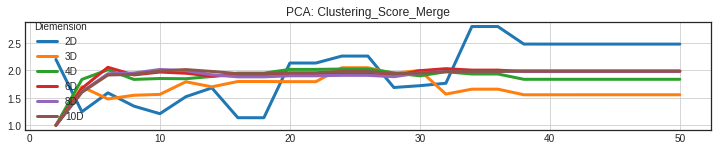

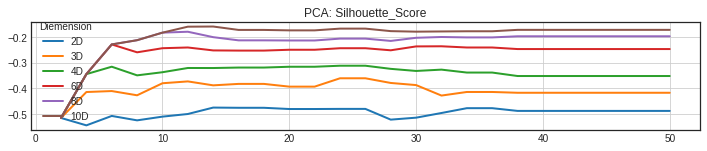

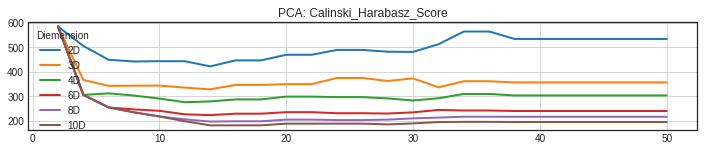

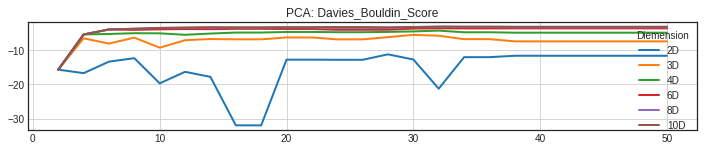

In [81]:
metric_score_PCA_merge.plot(title="PCA: Clustering_Score_Merge" , grid=True, figsize=(12.3, 2), lw=3);         # 三個指標標準化後加總
metric_score_PCA.silhouette.plot(title="PCA: Silhouette_Score",grid=True, figsize=(12, 2), lw=2);
metric_score_PCA.calinski_harabasz.plot(title="PCA: Calinski_Harabasz_Score",grid=True, figsize=(12, 2), lw=2);
metric_score_PCA.davies_bouldin.plot(title="PCA: Davies_Bouldin_Score",grid=True, figsize=(12, 2), lw=2);

In [83]:
metric_score_PCA_

Score_metrc silhouette                                                    \
Diemension          2D        3D        4D        6D        8D       10D   
2             0.417059  0.000000  0.000000  0.000000  0.000000  0.000000   
4             0.000000  0.653451  0.839151  0.596081  0.508346  0.479315   
6             0.529621  0.677985  0.981175  1.000000  0.852814  0.804110   
8             0.281727  0.571200  0.815557  0.892700  0.902007  0.850494   
10            0.490699  0.874784  0.875478  0.948526  0.989649  0.933137   
12            0.638620  0.921161  0.956648  0.958438  1.000000  0.998253   
14            1.000000  0.821996  0.956003  0.918575  0.937192  1.000000   
16            0.988122  0.858387  0.964935  0.916200  0.900111  0.962788   
18            0.988117  0.858385  0.964934  0.916200  0.900110  0.962788   
20            0.919324  0.789362  0.980363  0.927553  0.898579  0.957920   
22            0.919326  0.789364  0.980363  0.927553  0.898579  0.957920   
24            0.926350  1.000000  1.000000  0.948400  0.920246  0.977049   
26            0.926342  1.000000  0.999999  0.948399  0.920245  0.977048   
28            0.321981  0.882100  0.940197  0.920216  0.893478  0.949600   
30            0.432592  0.828462  0.899903  0.973082  0.929818  0.943719   
32            0.694937  0.564244  0.925177  0.974848  0.939083  0.946032   
34            0.966443  0.654735  0.869192  0.958287  0.934285  0.948118   
36            0.966438  0.654658  0.869186  0.958291  0.934284  0.948118   
38            0.812825  0.634739  0.802874  0.937088  0.947217  0.963587   
40            0.812716  0.634745  0.802863  0.937075  0.947213  0.963587   
42            0.812753  0.634763  0.802858  0.937089  0.947215  0.963587   
44            0.812735  0.634761  0.802857  0.937090  0.947213  0.963587   
46            0.812757  0.634782  0.802862  0.937085  0.947214  0.963587   
48            0.812747  0.634742  0.802852  0.937087  0.947214  0.963587   
50            0.812742  0.634746  0.802878  0.937095  0.947211  0.963587   

Score_metrc calinski_harabasz                                          \
Diemension                 2D        3D        4D        6D        8D   
2                    1.000000  1.000000  1.000000  1.000000  1.000000   
4                    0.512481  0.149252  0.096669  0.228149  0.280493   
6                    0.164993  0.054318  0.117073  0.086429  0.148374   
8                    0.122727  0.057867  0.087972  0.064495  0.096714   
10                   0.130298  0.059208  0.048221  0.048300  0.053611   
12                   0.130081  0.026802  0.000000  0.009155  0.023006   
14                   0.000000  0.000000  0.010501  0.000000  0.000000   
16                   0.150776  0.069488  0.037078  0.016220  0.003215   
18                   0.150779  0.069489  0.037079  0.016221  0.003215   
20                   0.291391  0.082699  0.073963  0.033313  0.020363   
22                   0.291390  0.082699  0.073963  0.033312  0.020363   
24                   0.413171  0.180432  0.067290  0.021343  0.015838   
26                   0.413168  0.180430  0.067290  0.021343  0.015839   
28                   0.367998  0.133009  0.050156  0.018002  0.020324   
30                   0.362643  0.173360  0.023003  0.031394  0.033608   
32                   0.555911  0.031729  0.051920  0.058450  0.041713   
34                   0.874476  0.128472  0.109255  0.052027  0.050950   
36                   0.874463  0.128456  0.109255  0.052028  0.050949   
38                   0.688387  0.110147  0.089341  0.046477  0.050467   
40                   0.688378  0.110159  0.089339  0.046478  0.050467   
42                   0.688372  0.110153  0.089341  0.046481  0.050467   
44                   0.688373  0.110160  0.089342  0.046479  0.050467   
46                   0.688367  0.110156  0.089346  0.046476  0.050466   
48                   0.688386  0.110166  0.089360  0.046478  0.050467   
50                   0.688371  0.110158  0.089341

In [205]:
n_union = np.arange(2,52,2)
# n_union = [100,200,300]

# metric = "silhouette"
# sil_score_2D, sil_score_3D = clustering_metric_score(metric=metric , n_union=n_union, dim=2), clustering_metric_score(metric=metric, n_union=n_union, dim=3)

# metric = "calinski_harabasz"
# ch_score_2D, ch_score_3D = clustering_metric_score(metric=metric , n_union=n_union, dim=2), clustering_metric_score(metric=metric, n_union=n_union, dim=3)

# metric = "davies_bouldin"
# db_score_2D, db_score_3D = clustering_metric_score(metric=metric , n_union=n_union, dim=2), clustering_metric_score(metric=metric, n_union=n_union, dim=3)

In [227]:
# columns  = pd.MultiIndex.from_product([[ "silhouette" , "calinski_harabasz", "davies_bouldin"], ['2D', '3D']], names=['Score_metrc', 'Diemension'])
# metric_score = pd.DataFrame( 
#     np.array([sil_score_2D, sil_score_3D, 
#               ch_score_2D, ch_score_3D,
#               db_score_2D, db_score_3D]).T,     # 轉置資料方向
#              columns=columns,
#              index=n_union
#             )
# metric_score.to_csv('meta/clustering_metric_score_UMPA.csv')
metric_score_UMAP = pd.read_csv('meta/clustering_metric_score_UMPA.csv',header=[0,1],  index_col=0)
metric_score_UMAP = metric_score_UMAP[:-1]

In [230]:
#　將三個metric標準化處理，取值在0~1。
metric_score_UMAP.davies_bouldin = metric_score_UMAP.davies_bouldin*-1  # davies_bouldin為越小越佳，因此先乘上負號
metric_score_UMAP_ = (metric_score_UMAP -  metric_score_UMAP.min()) / (metric_score_UMAP.max() -  metric_score_UMAP.min())
# idx = pd.IndexSlice
# metric_score_.loc[:, idx[:, "2D"]].sum(axis=1)
# metric_score_.loc[:, idx[:, "3D"]].sum(axis=1)
metric_score_UMAP_merge = metric_score_UMAP_.sum(axis=1, level="Diemension")
print(metric_score_UMAP_merge.loc[:50].idxmax())  # 檢視分群最佳結果的 N_union
print(metric_score_UMAP_merge.loc[:50].max())

Diemension
2D    42
3D    46
dtype: int64
Diemension
2D    1.754327
3D    1.784814
dtype: float64


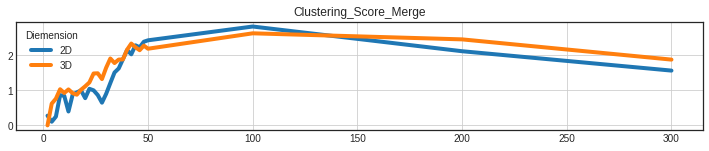

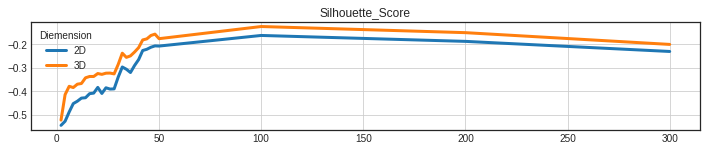

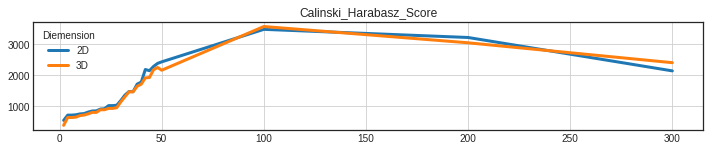

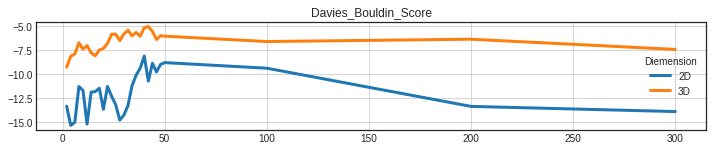

In [229]:
metric_score_UMAP_merge.plot(title="Clustering_Score_Merge" , grid=True, figsize=(12.3, 2), lw=4);         # 三個指標標準化後加總
metric_score_UMAP.silhouette.plot(title="Silhouette_Score",grid=True, figsize=(12, 2), lw=3);
metric_score_UMAP.calinski_harabasz.plot(title="Calinski_Harabasz_Score",grid=True, figsize=(12, 2), lw=3);
metric_score_UMAP.davies_bouldin.plot(title="Davies_Bouldin_Score",grid=True, figsize=(12, 2), lw=3);

#### Note:
- 2D時， N-union=42時，時有最佳的科分群結果(1.754)
- 3D時， N-union=46時，時有最佳的科分群結果(1.785)

- 標準化並加總評估後得到當 N=2, N-union=34 時有最佳的科分群結果，約為總特徵數的 6.6% (34/512)??
- pca可以檢視變異百分比，UMAP如何檢視

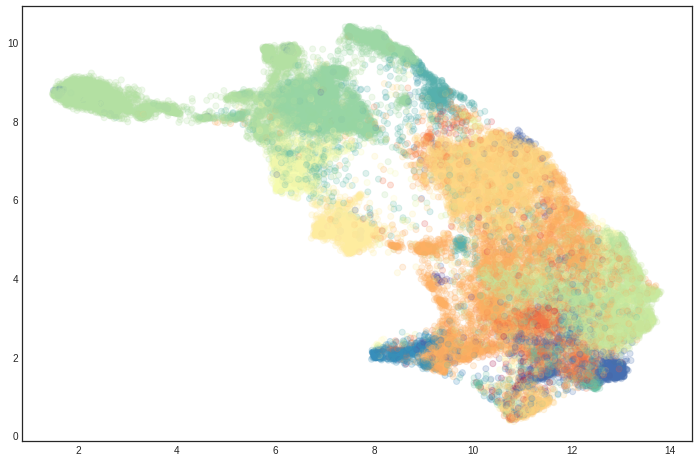

In [195]:
embedding_file = "umap_embedding_2D_50N.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
# np.save(path, embedding_1024)
embedding =  np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding = pd.concat( [pd.DataFrame(embedding) , meta_], axis=1)
fig = plt.figure(figsize=(12,8))
plt.scatter(embedding.iloc[:, 0], embedding.iloc[:, 1], alpha=0.2,
            c=embedding.iloc[:, 3],
            cmap='Spectral'
           );

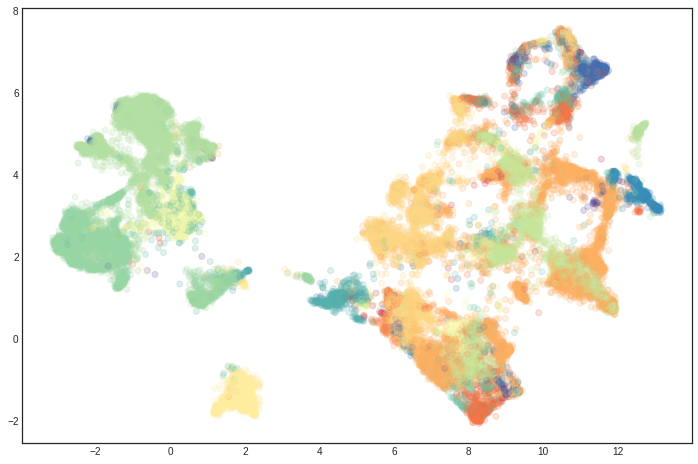

In [193]:

embedding_file = "umap_embedding_2D_300N.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
# np.save(path, embedding_1024)
embedding =  np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding = pd.concat( [pd.DataFrame(embedding) , meta_], axis=1)
fig = plt.figure(figsize=(12,8))
plt.scatter(embedding.iloc[:, 0], embedding.iloc[:, 1], alpha=0.2,
            c=embedding.iloc[:, 3],
            cmap='Spectral'
           );

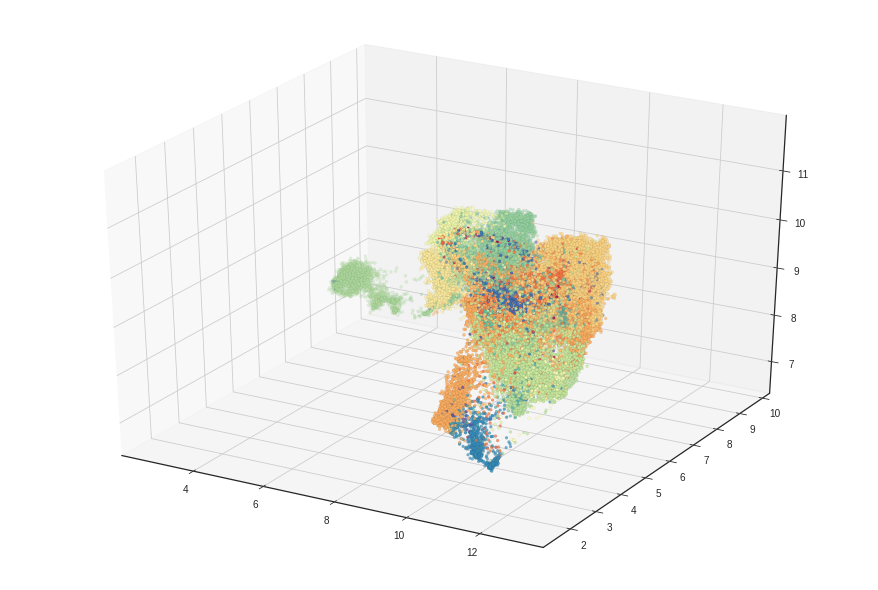

In [192]:
embedding_file = f"umap_embedding_3D_50N.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
embedding = np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding_ = pd.concat( [pd.DataFrame(embedding) , meta_], axis=1)

fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
scatter = ax.scatter(embedding_.iloc[:, 0], embedding_.iloc[:, 1], embedding_.iloc[:, 2],
                     c=embedding_.iloc[:, 4],
                     cmap='Spectral', lw=.05, s=9, edgecolors='black');

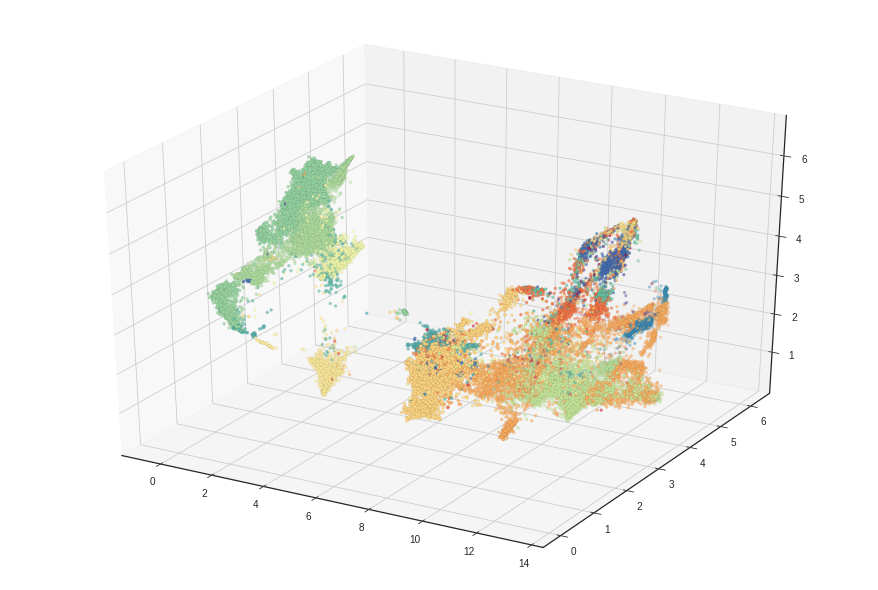

In [190]:
embedding_file = f"umap_embedding_3D_100N.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
embedding = np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding_ = pd.concat( [pd.DataFrame(embedding) , meta_], axis=1)

fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
scatter = ax.scatter(embedding_.iloc[:, 0], embedding_.iloc[:, 1], embedding_.iloc[:, 2],
                     c=embedding_.iloc[:, 4],
                     cmap='Spectral', lw=.05, s=9, edgecolors='black');

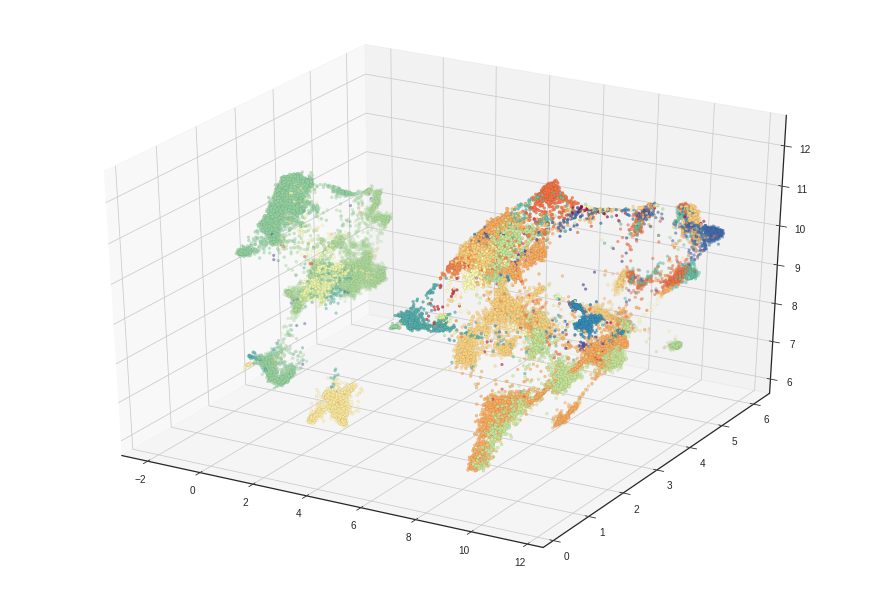

In [191]:
embedding_file = f"umap_embedding_3D_300N.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
embedding = np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding_ = pd.concat( [pd.DataFrame(embedding) , meta_], axis=1)

fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)
scatter = ax.scatter(embedding_.iloc[:, 0], embedding_.iloc[:, 1], embedding_.iloc[:, 2],
                     c=embedding_.iloc[:, 4],
                     cmap='Spectral', lw=.05, s=9, edgecolors='black');

- 需要透過反選取，將此維度以外的變為0

### 2.3 PCA降維(3軸)，在三軸上內插取樣、並inverse transform 回關鍵特徵後，使用decoder生成影像，檢視特徵維度的視覺變化
- 為了更進一步理解關鍵特徵的視覺意義，我們對其做 PCA，找出最主要的三軸(解釋度 34.9%)。接著在三軸上均勻取樣並 inverse transform 回關鍵特徵。從 decoder 生成的影像中，可明確看出每一軸在外觀特徵上的意義，是為：展翅大小、翅膀形狀，與翅膀上的紋路(圖5)。

- 凍結其他不重要維度(設為0)，依重要性(投票數量)分別選取 1-50 個重要維度進行投影分群(採用UMAP)
- 利用分群指標檢視分群分數，找出最佳分群結果時的參數，包含n_components(主成分數量)、(特徵數量)

In [ ]:
ck = 4300
features = np.load(f'./meta//features_ck{ck}.npy')
features.shape

In [116]:
n_components = 2

pca = PCA(n_components=n_components)
mapper_pca = pca.fit(key_features)

In [118]:
embedding_pca =  pca.transform(key_features)
root = f'./meta/embedding/pca_embedding_{n_components}D.npy'
np.save(root, embedding_pca)

In [119]:
embedding_ = pd.DataFrame(np.load(f'./meta/embedding/pca_embedding_{n_components}D.npy'))

meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding_pca = pd.concat( [embedding_ , meta_], axis=1)

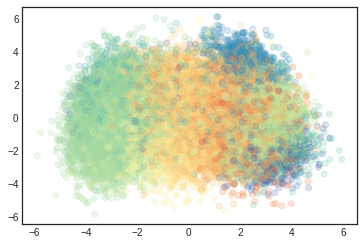

In [120]:
plt.scatter(embedding_pca.iloc[:, 0], embedding_pca.iloc[:, 1], alpha=0.2,
            c=embedding_pca.iloc[:, 3],
            cmap='Spectral'
           );

In [ ]:
features_new = pca.inverse_transform(embedding_pca)

In [ ]:
plt.scatter(features_new[:, 0], features_new[:, 1], alpha=0.2,
            c=embedding.iloc[:, 3],
            cmap='Spectral'
           );

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print(pca.n_components_) # return 509

#### UMAP

In [1]:
n_components=2; n_neighbors=200
reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, verbose=True)

NameError: name 'umap' is not defined

In [44]:
mapper = reducer.fit(features_1024)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=200, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Jun 16 13:55:10 2021 Finding Nearest Neighbors
Wed Jun 16 13:55:10 2021 Building RP forest with 14 trees
Wed Jun 16 13:55:15 2021 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Wed Jun 16 14:03:27 2021 Finished Nearest Neighbor Search
Wed Jun 16 14:03:41 2021 Construct embedding
	completed  0  /  200 epo

In [ ]:
mapper

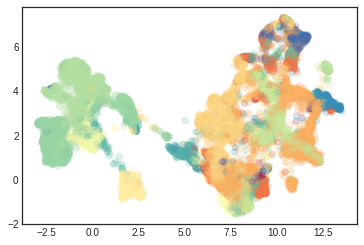

In [50]:
# embedding_1024 = reducer.transform(features_1024)
embedding_file = f"umap_embedding_1024_{n_components}D.npy"
path =  f'{path_root}/meta/embedding/{embedding_file}'
# np.save(path, embedding_1024)
embedding_1024 =  np.load(path)
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
embedding = pd.concat( [pd.DataFrame(embedding_1024) , meta_], axis=1)
plt.scatter(embedding.iloc[:, 0], embedding.iloc[:, 1], alpha=0.2,
            c=embedding.iloc[:, 3],
            cmap='Spectral'
           );

In [ ]:
# 計算非常耗時，取部分樣本即可
inv_transformed_points = mapper.inverse_transform(embedding[:1000])
inv_transformed_points.shape

In [ ]:
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
inv_transformed_points = pd.concat( [pd.DataFrame(inv_transformed_points) , meta_], axis=1)
plt.scatter(inv_transformed_points.iloc[:, 0], inv_transformed_points.iloc[:, 5], alpha=0.2,
            c=embedding_pca.iloc[:, 3],
            cmap='Spectral'
           );

In [ ]:
meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
inv_transformed_points = pd.concat( [pd.DataFrame(inv_transformed_points) , meta_], axis=1)
plt.scatter(features[:, 0], features[:, 5], alpha=0.2,
            c=embedding_pca.iloc[:, 3],
            cmap='Spectral'
           );

In [ ]:
umap.plot.points(mapper, labels=meta_.Family_encode, background='black');

- 直接用PCA抓到的解釋力很低
- 前面的投票找出關鍵特徵的維度與這邊PCA的關係是...?

In [ ]:
def cluster_2DplotByS(n_neighbors=200, metric='euclidean', sample=500, save=None):    
    
    # 取得基本資料
    index = moth_meta[f_meta.Fam_Sample > sample].index                    # 指定取樣的科數。 依據樣本Fam_Sample 或依據物種數Fam_Specie
    embedding_ = pd.DataFrame(np.load(f'./meta/embedding_2D_{metric}_{n_neighbors}.npy'))
    meta_ = moth_meta[['Family','Family_encode']]                          # 取得科的標籤 
    embedding = pd.concat( [embedding_ , meta_], axis=1)
    sample_list = embedding.iloc[index,:].Family.sort_values().unique() # 從已篩選過樣本數量的embedding中建立類別(科)清單
    print('Samole Number:', len(sample_list), sample_list)
    
    for i, f in enumerate(sample_list):
        print(f'Ploting {f} ...')
        plt.close()                                                     # 清空前一張圖避免重疊繪圖，以及釋放記憶體空間
        fig = plt.figure(figsize=(16,9),clear=True)
        ax = plt.subplot()
        indexByS = moth_meta[f_meta.Family == f].index                     # 取得單一物種的index位置 
        
        ax.scatter(embedding.iloc[index, 0], embedding.iloc[index, 1],  # 建立所有類別的scatter底圖
                    c='lightgrey', lw=.1, s=3)

        # 建立單一欲顯色的類別scatter圖
        scatter = ax.scatter(embedding.iloc[indexByS, 0], embedding.iloc[indexByS, 1],
                             c=embedding.iloc[indexByS, 3],
                             lw=.1, s=9, edgecolors='b', cmap='Spectral')
        
        # 取出legen元素，圖標 handles與 標籤labels
        handles, labels = scatter.legend_elements()  # labels
        family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
        ax.legend(
        #     *scatter.legend_elements(),
            handles=handles, labels=family_list,
            title='Family', ncol=4, markerscale=1)

        plt.title(f'UMAP_Moth - {f}', fontsize=24)
        plt.suptitle(f'n_neighbors:{n_neighbors},\n sample>{sample} ', x=0.75, y=0.92, fontsize=12, fontweight='light')
        plt.gca().set_aspect('equal', 'datalim');
        if save==True:
            plt.savefig(f"./results/umap/Umap_2D_sample{sample}_neighbor{n_neighbors}_{f}.png", bbox_inches='tight')
        